<a href="https://colab.research.google.com/github/Surichn/DSAI/blob/main/DA/FD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Fraud Detection**

In [2]:
import pandas as pd
import numpy as np

In [3]:
!pip install pyod

     |████████████████████████████████| 114 kB 5.0 MB/s 
  Created wheel for pyod: filename=pyod-0.9.7-py3-none-any.whl size=136279 sha256=e49ed0198907d34fbac15db70b35b67ced3a9e32c9135e11b3e34f58cbe1f06f
  Stored in directory: /root/.cache/pip/wheels/ce/14/ae/60cbb36511e59bc12f8f0883805f586db3b315972b54865d33
Successfully built pyod


In [5]:
!pip install combo

  Created wheel for combo: filename=combo-0.1.2-py3-none-any.whl size=42026 sha256=06f0f959cf5114a155480061b224e91e1cd3d62d2a399de15cc06415c54ee633
  Stored in directory: /root/.cache/pip/wheels/cf/2e/45/d4cb985fb061e3ab636d350b76114d2639d84eab16225c7776
Successfully built combo


In [6]:
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF


In [7]:
# reading the big mart sales training data
url = "https://raw.githubusercontent.com/Surichn/DSAI/main/DA/BM_Train.csv"
df = pd.read_csv(url)

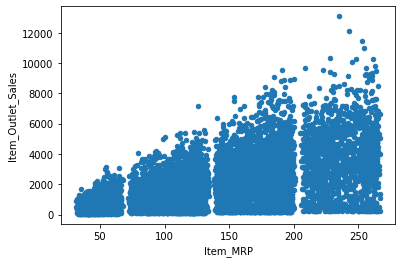

In [8]:
df.plot.scatter('Item_MRP','Item_Outlet_Sales')